# Breast Cancer Analysis
## By: Mason Nolan


---

In this notebook, we will be practicing data pre-processing methods to improve the quality of our dataset, and then using the data with a decision tree model. We will also perform dimensionality reduction via PCA and we will compare the model before and after to see how our model may have been improved. The dataset we will be using is a famous dataset from Wisconsin which lists characteristics of masses in breasts examined after fine-needle aspiration. The dataset source can be viewed here:  [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

# Dataset Overview

Let's first look at the first few entries of our dataset to see what we are working with:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
breastcan = pd.read_csv('/content/drive/My Drive/R Data/Data/BreastCancerWisconsin.csv')
print(breastcan.head(6)) # We will visualize a bit of the data to get an idea of what we are looking at
print("-------------------------------------------------------------------------------------------")
print(f'Shape of data:', breastcan.shape) # We will also check the sample size
print("-------------------------------------------------------------------------------------------")
breastcan.info() # Checking all categories and doing a count of missing values.

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   
5    843786         M        12.45         15.70           82.57      477.1   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980         

Our target is the diagnosis of each patient. The possible diagnosis are either malignant (M) or benign (B). This is categorical data, so we will have to encode this into 1s for malignant and 0s for benign in order for our decision tree to process it properly.

The first column of data is for the sampled patient's ID, but this is clearly not relevant to breast cancer diagnosis so we will remove this column. The last column of data is entirely empty, so there must have been some sort of reading error with the csv file. This can be removed as well with no impact on the overall data quality.

There is no other categorical data, so the target is the only column we will have to encode. If there were more columns of categorical data, we would use one-hot encoding to mark each possible label for each patient.

The remaining columns are continuous features from mass samples from the patient: radius, texture (variation of color in the picture of the mass), perimeter, area, smoothness (variation of radii), compactness (a metric based on ratio of perimeter to area [(see more)](https://en.wikipedia.org/wiki/Compactness_measure)), concavity (based on depth of concave portions), number of concave points, symmetry, and fractal dimension (a metric of complexity of the shape of the mass [(see more)](https://en.wikipedia.org/wiki/Fractal_dimension)). Each of these 10 primary features are split into 3 columns, for the feature's mean, standard error, and maximum (labelled "worst"). This gives us a total of 30 features.

Another important point is whether or not our data will need to be standardized or normalized. Since we are planning on using a decision tree model, scaling is not *typically* necessary, as a decision tree splits data based on change in information gain, which is not dependant on magnitudes of features. However, in this notebook we plan on dirtying our data by deleting some of our and using k-nearest neighbors to fill in missing values. K-Nearest neighbors is heavily dependant on the scale between our features since it revolves around taking the Euclidean distance between a new data point and observed data points, and therefore we would desire our feature data to be on the same scale so this algorithm is not biased towards certain features. Observing our data, we see that scaling will definitely need to be done: for example, look at our dataset's header where we see examples of features, say, maximum area, going up to values in the thousands, while a feature like maximum smoothness hovers around values near 0.15. Without scaling our features, then a feature like maximum smoothness would be heavily overrepresented by kNN while maximum area would be neglected, since a random new point might only be around ~0.01 distance from a nearby max smoothness value, while that same point might realistically be ~300 distance from the nearest max area value, so the algorithm may consider the factor of smoothness "much nearer" than area than it should actually be considered. We will decide to standardize our data over normalization since standardization will keep information about outliers, and it is not unreasonable to assume the types of features we have listed would follow approximately a normal distribution.

Lastly for preprocessing, we should check if our target classes are unbalanced. Our data may be overrepresenting benign or maligant masses, and if so, may cause our decision tree model to poorly represent the minority class when training. Let us check the totals of our target data:

In [3]:
print(pd.Series(breastcan['diagnosis']).value_counts())

diagnosis
B    357
M    212
Name: count, dtype: int64


We do see that our classes are unbalanced, though not egregiously so. Malignant masses make up 37% of our samples, and benign masses make up the other 63%. For the sake of brevity, we will not artifically balance our classes in this notebook, since the degree of unbalancedness is small and will not likely have a major impact on our models, so we would rather not mess with our collected data. If we *did* want to rebalance our classes, we would implement random sampling with replacement to copy some of the malignant cases in our training data, or use SMOTE.

With all of that in mind, we are ready to start modifying our data.

## Data Preprocessing

First, lets encode our only categorical data. Scikit encodes target labels by itself if they are strings, but it is good form for us to encode it ourselves. Encoding categorical data is important for decision tree models since they need to decide where to split data in order to seperate the data into two groups based on which gains the most information at each split. Splitting data at a certain numeric point where some data is above a certain value and the rest is below makes sense for continuous data, but not for categorical data. Therefore, we transform the labels into numbers.

In [4]:
pd.set_option("future.no_silent_downcasting", True) # This setting option is just to ignore outputting a warning that was appearing about the "replace" function being altered in future patches

# We replace all of our categorical data with 1s and 0s
breastcan=breastcan.replace("M",1)
breastcan=breastcan.replace("B",0)
breastcan['diagnosis']

,diagnosis
0,1
1,1
2,1
3,1
4,1
...,...
564,1
565,1
566,1
567,1


Now we will remove the unimportant columns: the ID column and the void column.



In [5]:
breastcan = breastcan.drop(['id','Unnamed: 32'], axis=1)
print(breastcan.shape)

(569, 31)


Next, we can split our data into our target vector and our feature matrix.

In [6]:
X = breastcan.drop(['diagnosis'], axis=1)
y = breastcan["diagnosis"]

Now, although our data was clean and did not have any values NaN values (other than the void column we removed), we have been asked to remove some random data values and simulate the missing values using k-nearest neighbors. We will need to scale our data before using the algorithm as well.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
breastcan_scaled = scaler.fit_transform(X)
breastcan_scaled_df = pd.DataFrame(breastcan_scaled, index=X.index, columns=X.columns)

S = 0.25
breastcanmissing = breastcan_scaled_df.mask(np.random.choice([True, False], size=breastcan_scaled_df.shape, p=[S, 1-S]))
breastcanmissing

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,NaN,-2.073335,1.269934,NaN,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,NaN,NaN,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,NaN,-0.023846,0.548144,0.001392,NaN,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,NaN,-0.146749,1.087084,-0.243890,NaN
2,1.579888,NaN,NaN,1.558884,0.942210,1.052926,1.363478,2.037231,NaN,-0.398008,...,NaN,-0.023974,NaN,NaN,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,NaN,NaN,-0.764464,NaN,3.402909,1.915897,NaN,2.867383,4.910919,...,NaN,NaN,-0.249939,-0.550021,3.394275,3.893397,1.989588,NaN,NaN,4.935010
4,1.750297,NaN,1.776573,NaN,0.280372,0.539340,1.371011,1.428493,NaN,NaN,...,1.298575,NaN,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,NaN,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,NaN,-1.360158,NaN
565,1.704854,2.085134,1.615931,NaN,0.102458,NaN,NaN,1.263669,-0.217664,NaN,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,NaN,0.733827,-0.531855,-0.973978
566,0.702284,2.045574,NaN,0.577953,-0.840484,-0.038680,0.046588,NaN,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,NaN,0.414069,NaN,-0.318409
567,1.838341,2.336457,NaN,1.735218,1.525767,NaN,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,NaN,NaN,NaN,2.219635


We will now use kNN to refill these missing values:

In [8]:
from sklearn.impute import KNNImputer

# 3. Impute Missing Values Using KNN
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(breastcanmissing)

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=breastcanmissing.columns)
imputed_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.588409,-2.073335,1.269934,1.701487,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,1.613079,1.998853,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,0.135826,-0.023846,0.548144,0.001392,-0.864967,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,0.026177,-0.146749,1.087084,-0.243890,-0.626521
2,1.579888,-0.038082,1.514603,1.558884,0.942210,1.052926,1.363478,2.037231,0.596496,-0.398008,...,1.716054,-0.023974,1.569678,1.662664,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.486439,-0.041727,-0.764464,2.334206,3.402909,1.915897,1.168180,2.867383,4.910919,...,-0.148103,1.514248,-0.249939,-0.550021,3.394275,3.893397,1.989588,1.435773,1.880903,4.935010
4,1.750297,0.619082,1.776573,1.453652,0.280372,0.539340,1.371011,1.428493,-0.073087,-0.352928,...,1.298575,0.733249,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,1.847420,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.232346,-1.360158,-0.045763
565,1.704854,2.085134,1.615931,1.399386,0.102458,0.172743,0.880413,1.263669,-0.217664,-0.740218,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.229857,0.733827,-0.531855,-0.973978
566,0.702284,2.045574,0.662213,0.577953,-0.840484,-0.038680,0.046588,0.203949,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.535363,0.414069,-0.080817,-0.318409
567,1.838341,2.336457,1.814468,1.735218,1.525767,2.152490,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,1.978746,1.863641,0.867849,2.219635


Let's view how our original data compares to the partial data that was filled in via our kNN algorithm by looking at a specific feature (average texture) and seeing how reasonably our algorithm approximated the original data's same feature values after imputation:

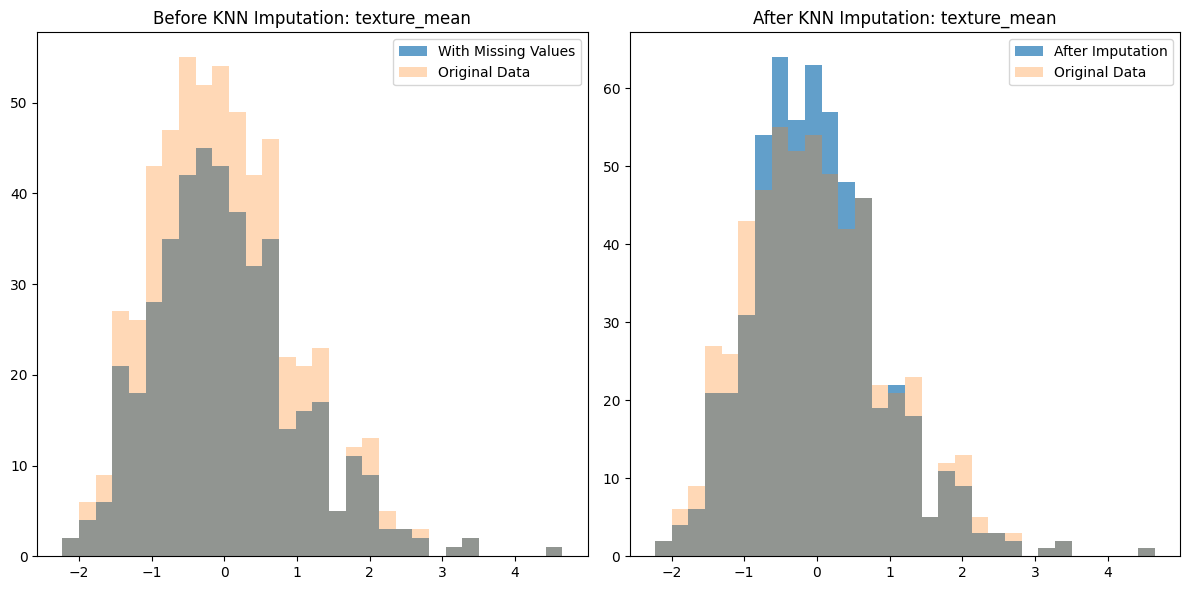

In [9]:
import matplotlib.pyplot as plt
def plot_missingness_before_after(original, missing, imputed, column):
    plt.figure(figsize=(12, 6))

    # Before
    plt.subplot(1, 2, 1)
    plt.hist(missing[column].dropna(), bins=30, alpha=0.7, label='With Missing Values')
    plt.hist(original[column], bins=30, alpha=0.3, label='Original Data')
    plt.title(f'Before KNN Imputation: {column}')
    plt.legend()

    # After
    plt.subplot(1, 2, 2)
    plt.hist(imputed[column], bins=30, alpha=0.7, label='After Imputation')
    plt.hist(original[column], bins=30, alpha=0.3, label='Original Data')
    plt.title(f'After KNN Imputation: {column}')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_missingness_before_after(breastcan_scaled_df, breastcanmissing, imputed_df, 'texture_mean')


Both plots show, in orange, approximately our original data's distribution for the scaled values of average texture. The gray histogram on the left plot is showing a seemingly reduced version of the orange histogram. This make sense, as the gray plot is simply the original plot with $S\cdot 100\%$ of its values removed. The second plot shows what happens after we fill those missing values with values computed by KNN imputation. We see that the bulk of our missing data was near the mean of the original histogram (which would always be the case after standardization anyways). The blue area above our gray plot in our right plot is indicating KNN overshooting and assigning too many values where there shouldn't be, while the orange areas in the right plot are indicating missing values that our KNN imputer did not fill in enough to match the original data. The KNN imputation seems to have overfilled near the mean and did not assign enough values to data that was further from the mean.

In the above plots, we had set $S=25\%$, where $S$ is the percentage of data missing from our dataset. Let's see how KNN performs as we vary our value of $S$:

-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 5.0 %


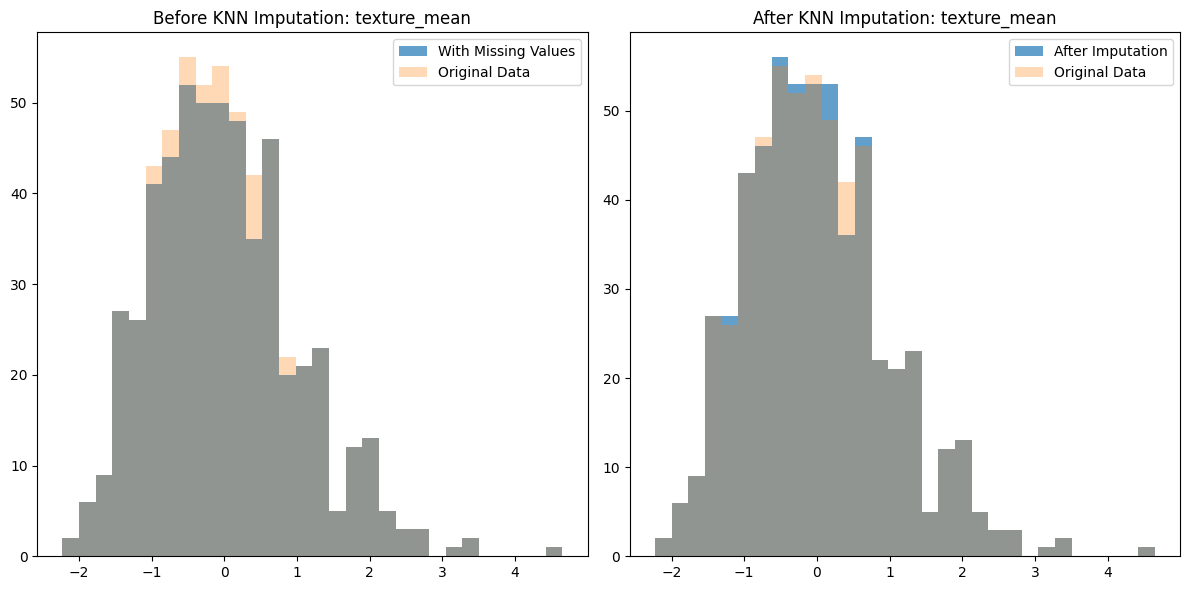

-----------------------------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 10.0 %


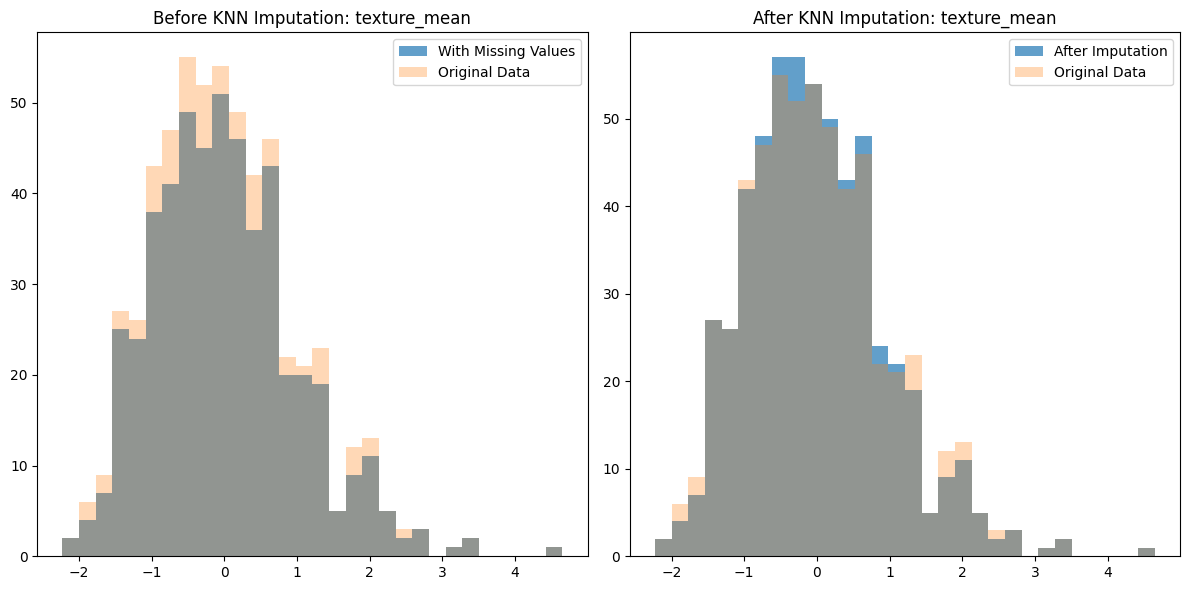

-----------------------------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 20.0 %


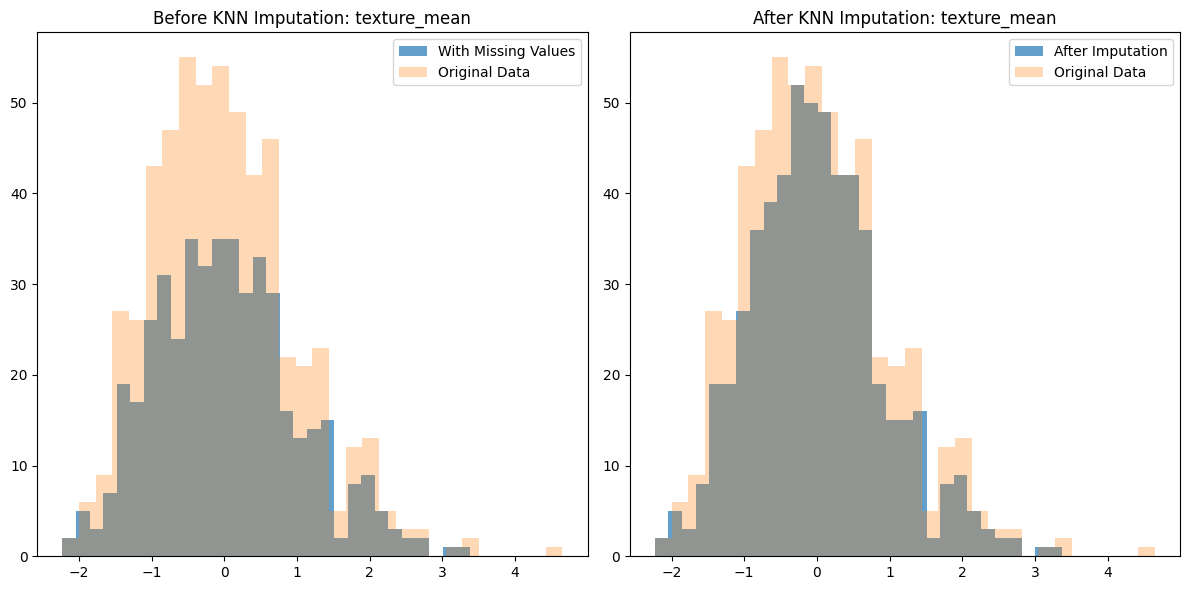

-----------------------------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 30.0 %


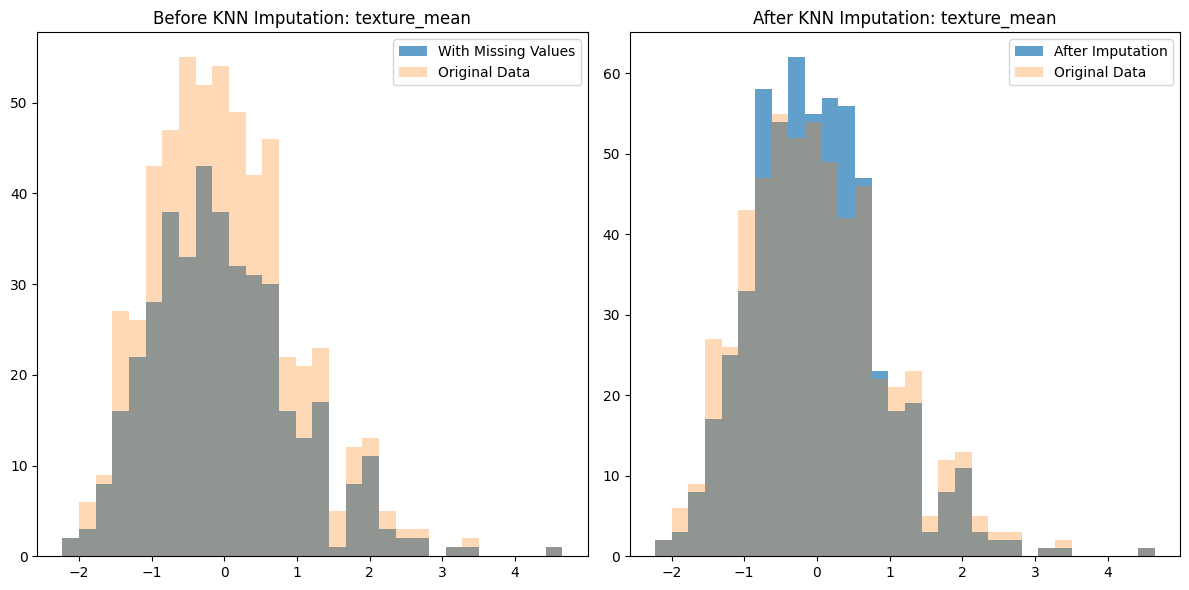

-----------------------------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 40.0 %


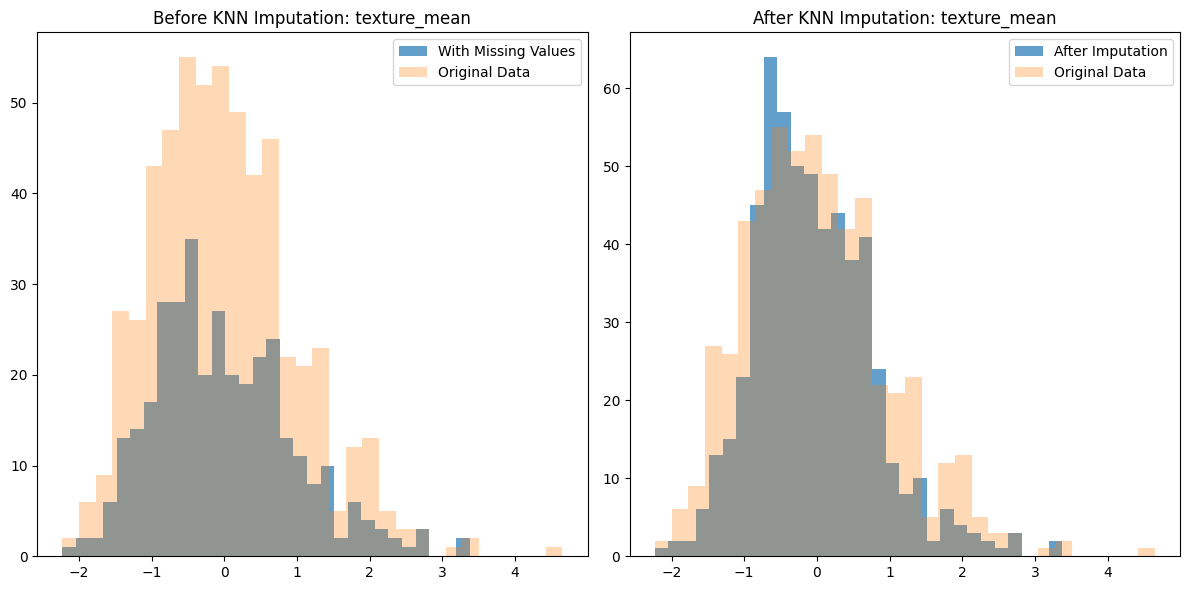

-----------------------------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 50.0 %


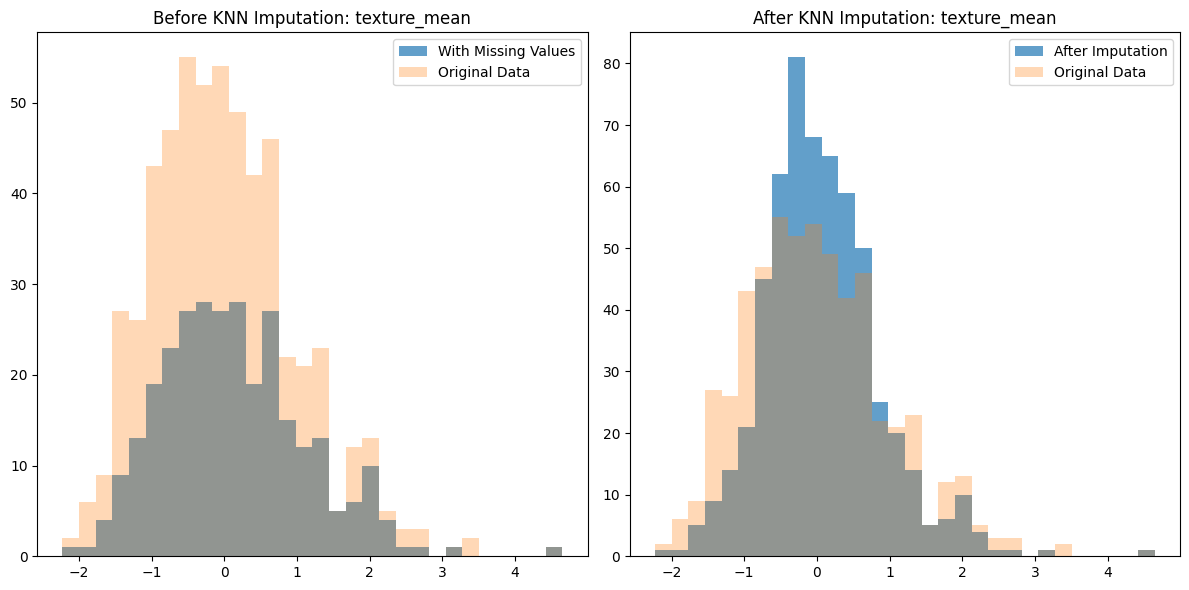

-----------------------------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------------------------
S = 75.0 %


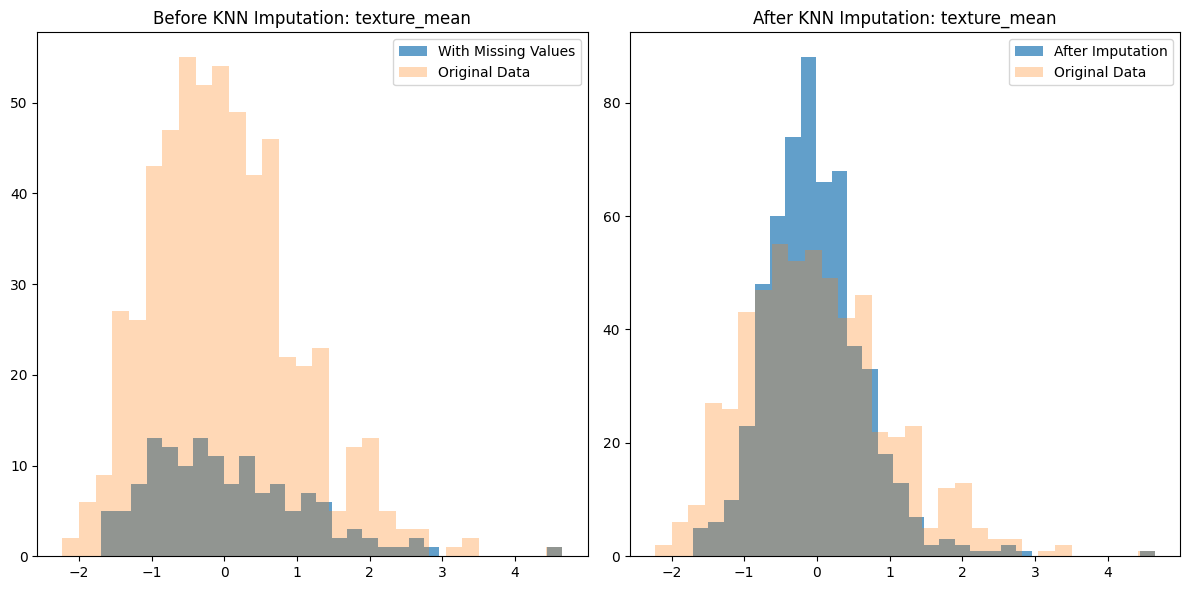

-----------------------------------------------------------------------------------------------------------------------------------------------------




In [10]:
for i in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75]:
  S_n=i
  print("-----------------------------------------------------------------------------------------------------------------------------------------------------")
  print(f'S =', i*100,'%')
  breastcanmissingloop = breastcan_scaled_df.mask(np.random.choice([True, False], size=breastcan_scaled_df.shape, p=[S_n, 1-S_n]))
  imputed_dataloop = imputer.fit_transform(breastcanmissingloop)
  imputed_dfloop = pd.DataFrame(imputed_dataloop, columns=breastcanmissingloop.columns)
  plot_missingness_before_after(breastcan_scaled_df, breastcanmissingloop, imputed_dfloop, 'texture_mean')
  print("-----------------------------------------------------------------------------------------------------------------------------------------------------\n\n")

If we inspect our above plots, we do see that across all values of $S$, we have that tendency towards the mean that we observed earlier. As $S$ increases, the KNN imputation process greatly favors filling in values near 0 and is less likely to predict values with large deviations (our generated distribution has a smaller standard deviation than the original distribution). This may be explained by the more limited amount of starting data pigeonholing our KNN generated values towards eachother, as the first few values generated are fairly likely to be near the mean just by chance, while further values will be computed based of off our data plus the first values we generated which may be close to the mean. As we compute more values, we would expect to accumulate more and more values near the mean. Therefore, we use KNN to clean our dataset reasonably well, as long as the amount of missing data is not too large. Else, the variation of our feature values may not be properly captured. For the rest of this notebook, we will continue to let $S=25\%$.



# Exploratory Analysis and PCA

Before designing any model for a dataset, we should always visualize the data.

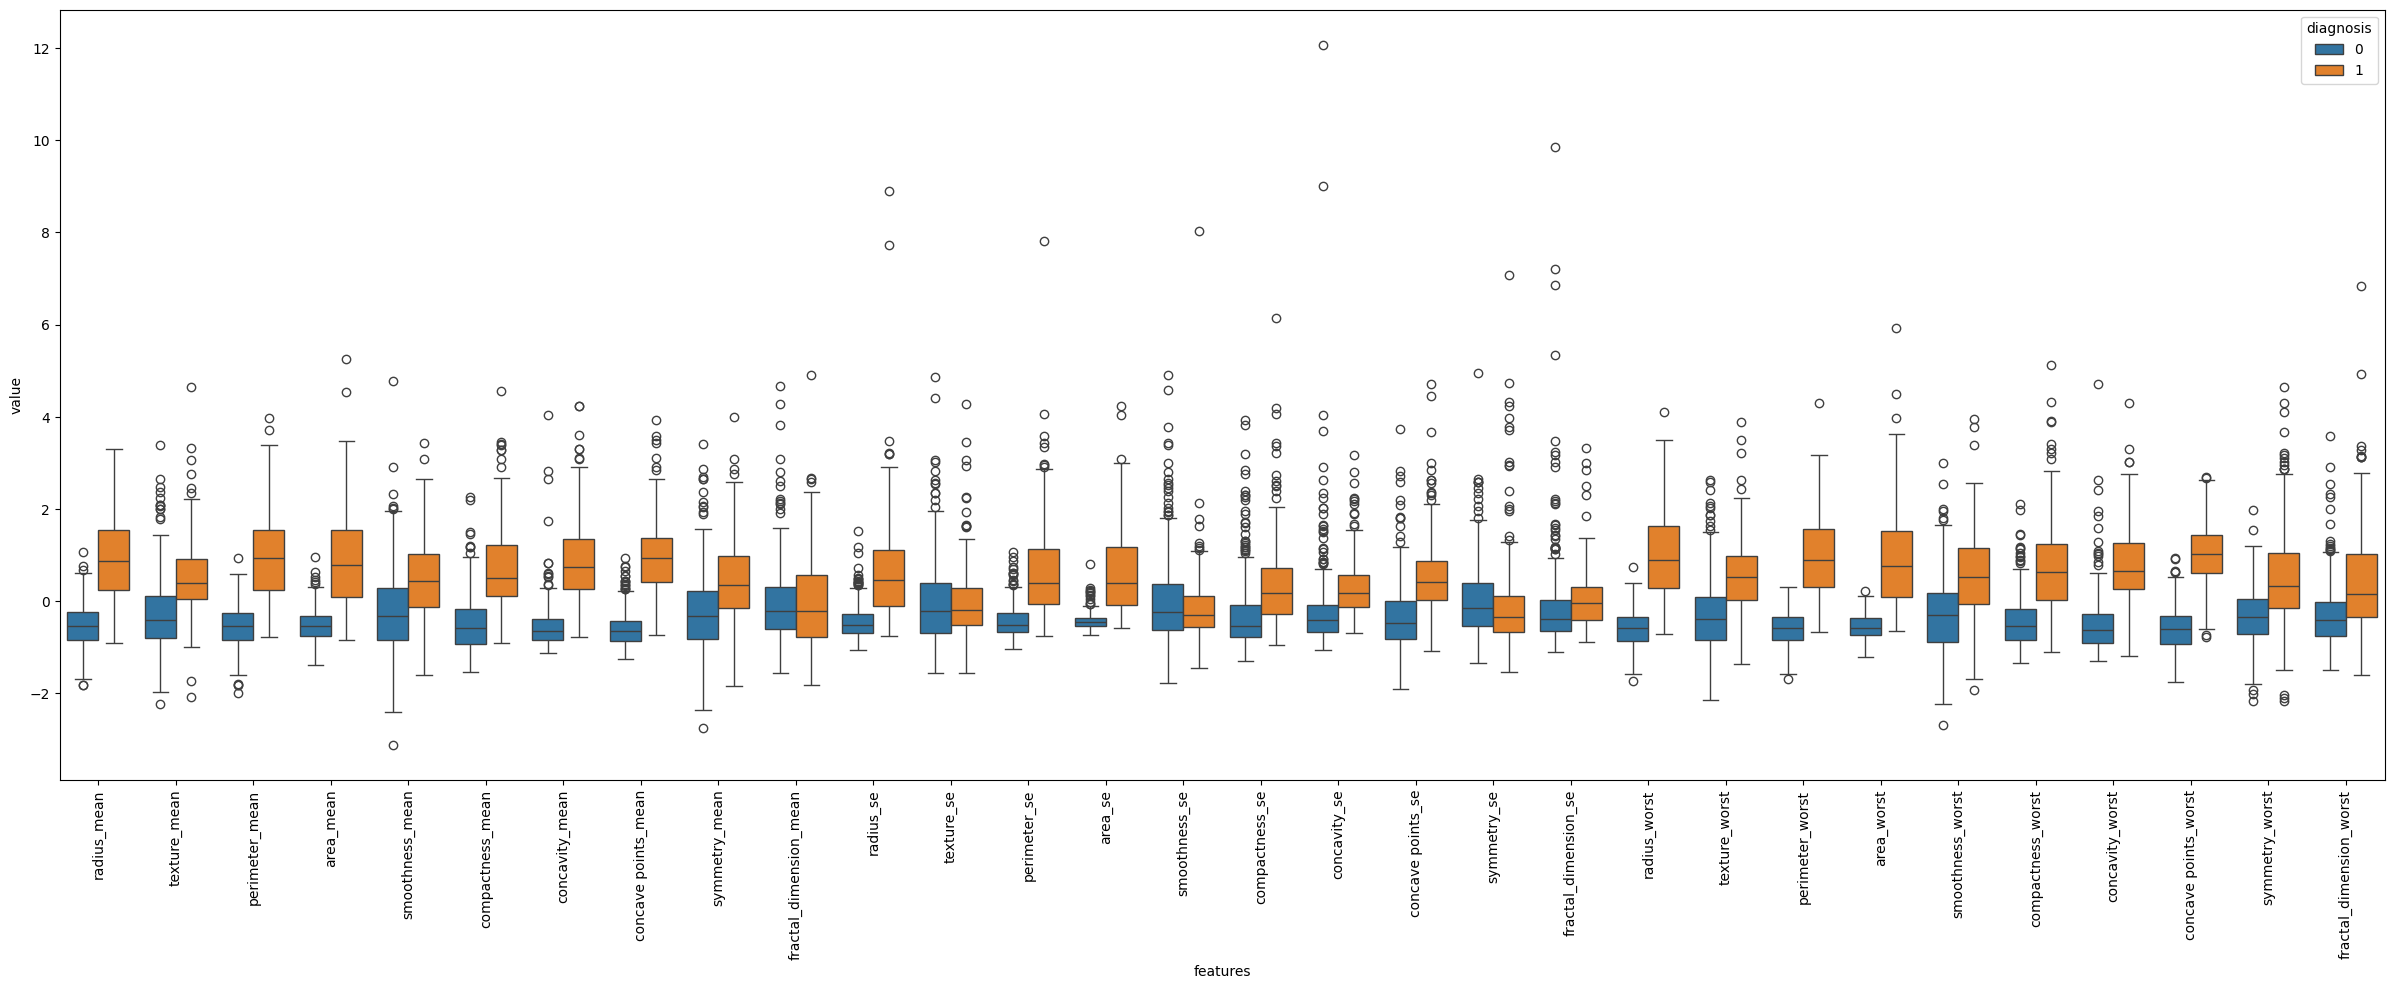

In [11]:
import seaborn as sns
data = pd.concat([y,imputed_df],axis=1)
data = pd.melt(data,id_vars="diagnosis",var_name="features",value_name='value')
plt.figure(figsize=(30,10))
sns.boxplot(data, x="features", y="value", hue="diagnosis")
plt.xticks(rotation=90)
plt.show()

We can see from our box plots that that malignant masses seem to typically have larger values for almost all features across the board on average (with the exceptions of possibly fractal dimension mean, texture standard error, smoothness standard error, and symmetry standard error). We also see that our data contains a very large amount of outliers, but given the sheer amount of samples we have, this amount may not be unusual relative to the amount of samples contained within each box plot's whiskers.

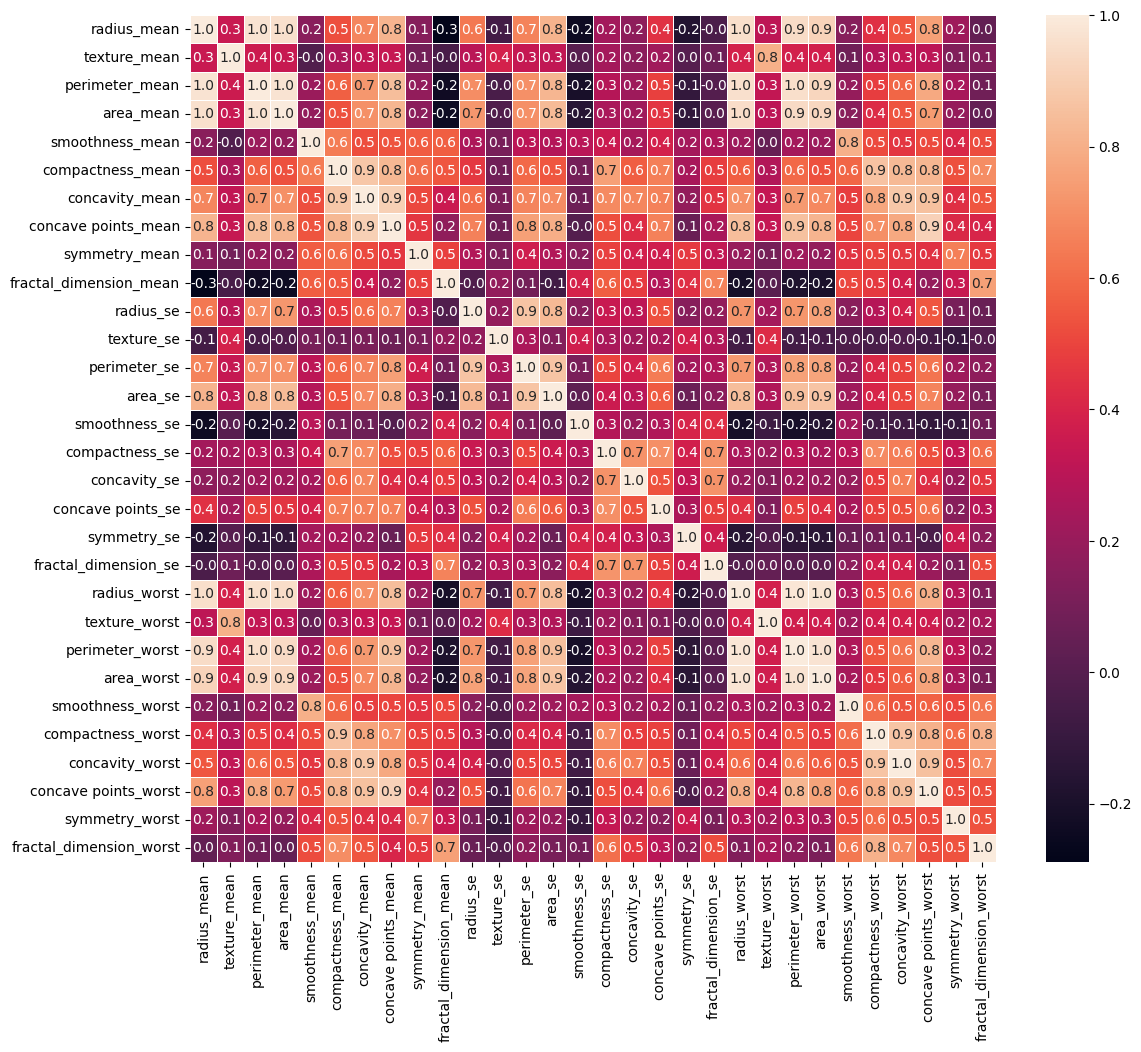

In [12]:
 plt.figure(figsize=(13,11))
 sns.heatmap(imputed_df.corr(), annot=True, linewidths=.5, fmt= '.1f')
 plt.show()

Our correlation matrix is quite large, but we can still point out some important facts about our data. Firstly, there is no strongly negatively correlated data (no values less than -0.2); most increases in any factor typically coinsides with an increase in almost every other factor. Secondly, we see a few features highly correlated with other features. For example, mean perimeter, mean area, and mean radius have near maximum correlation. This makes intuitive sense from a geometric point of view, since we would expect a random mass to be reasonably elliptic and the formulas for area and perimeter both rely on radius length. Likewise, we see similar correlation between radius, perimeter, and area's standard errors and maximums. We also see strong correlation between things like mean amount of concave points and mean value of concavity. That correlation needs almost no explanation.

The amount of highly correlated features may entail an increase of variance in our model due to multicollinearity.

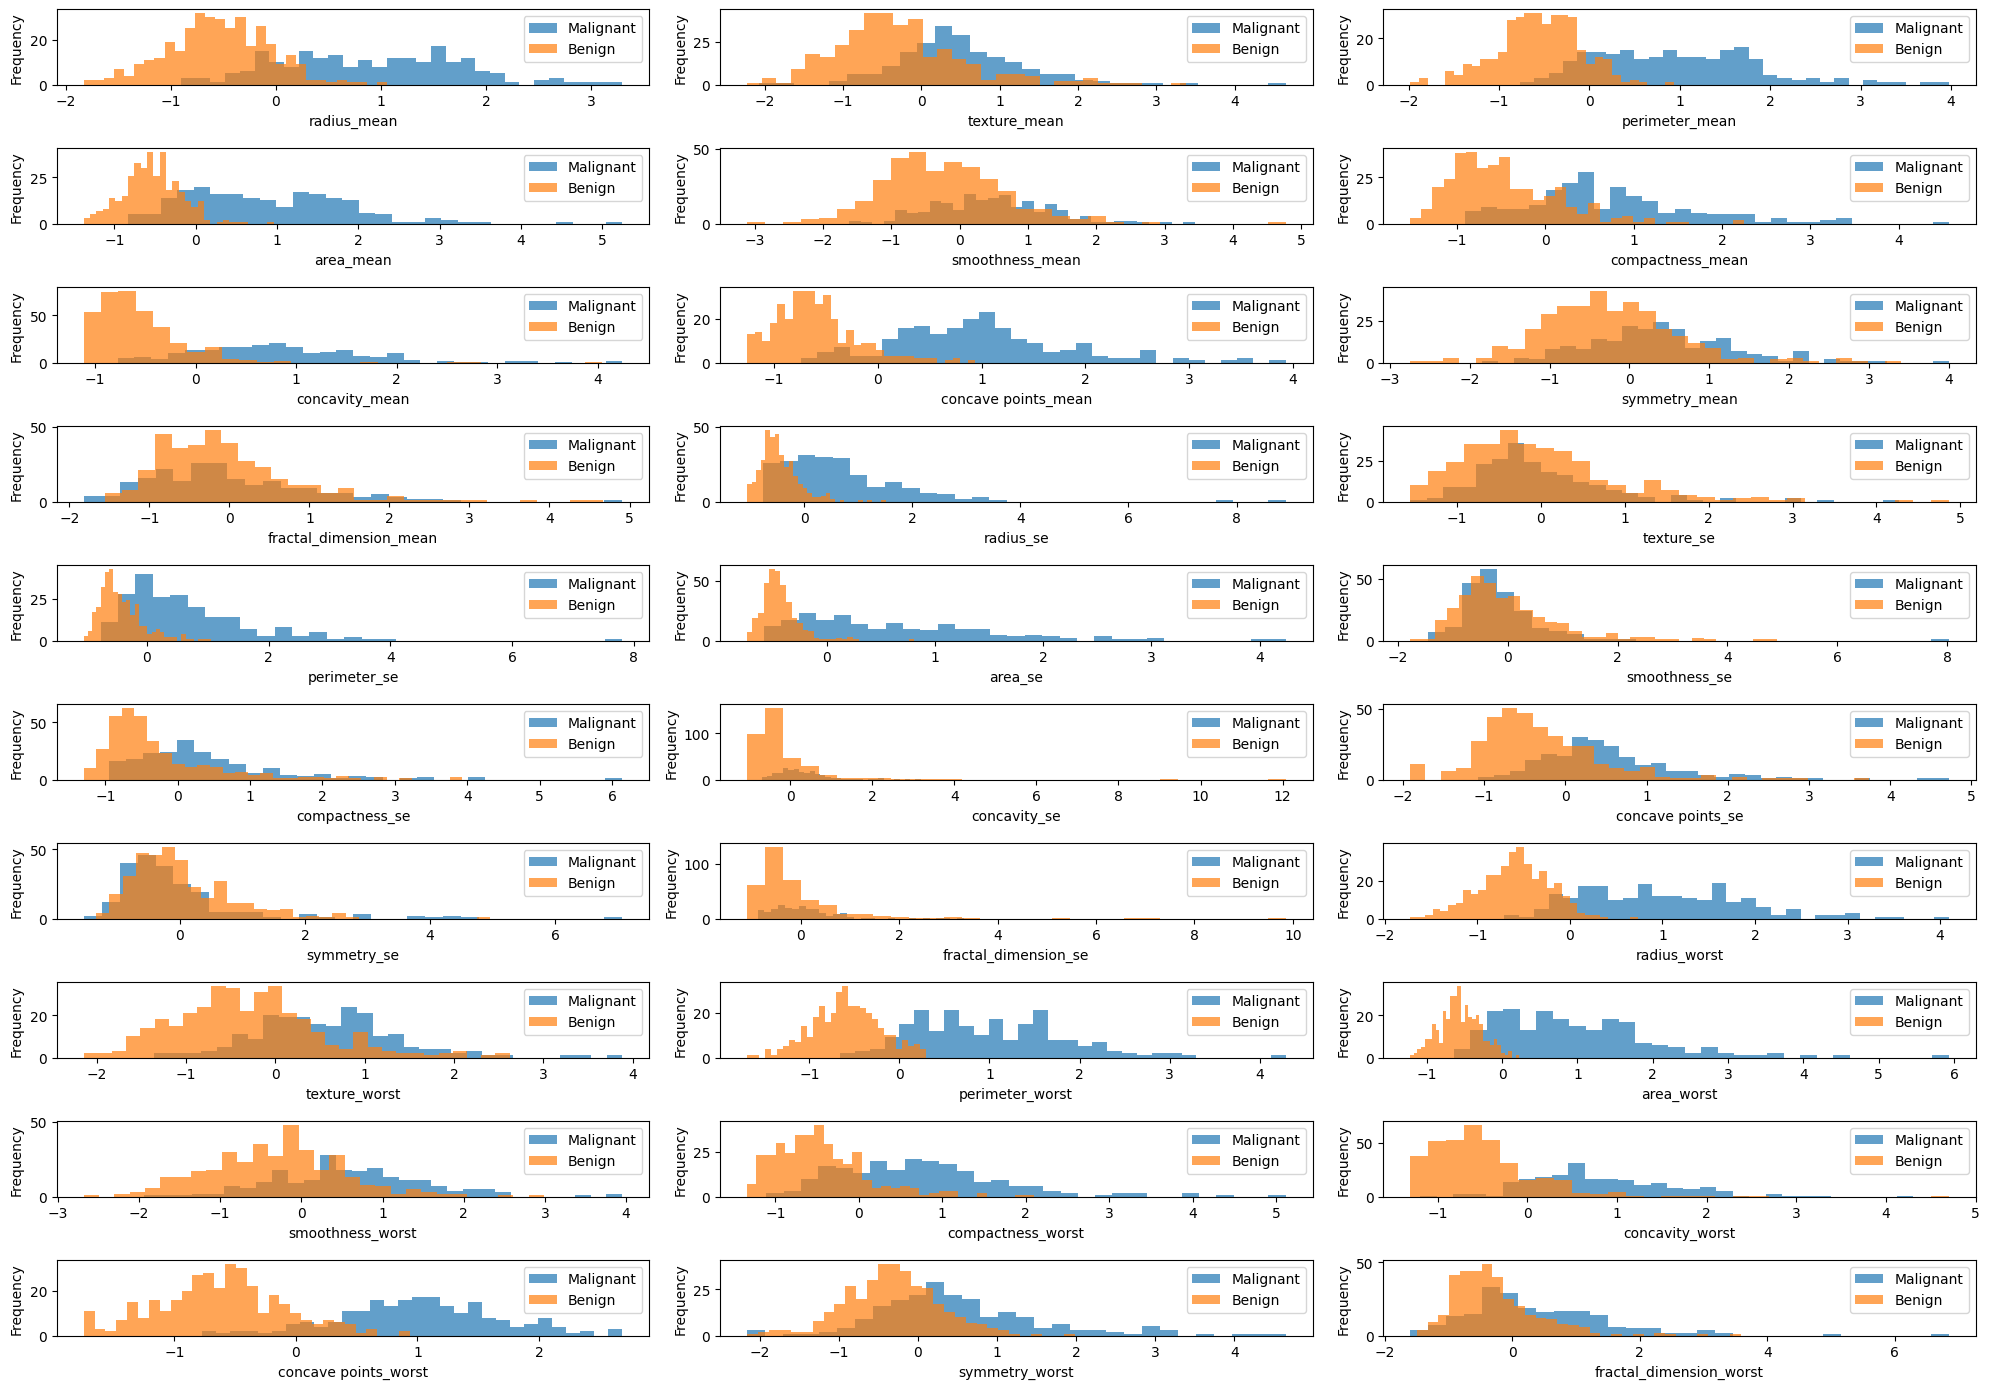

In [13]:
data = pd.concat([y,imputed_df],axis=1)
fig, axes = plt.subplots(10, 3, figsize=(20, 14))
for i in range(30):
  plt.subplot(10, 3, i+1)
  plt.hist(data[data["diagnosis"] == 1].iloc[:, i+1], bins=30, alpha=0.7, label="Malignant")
  plt.hist(data[data["diagnosis"] == 0].iloc[:, i+1], bins=30, alpha=0.7, label="Benign")
  plt.legend()
  plt.xlabel(data.columns[i+1])
  plt.ylabel("Frequency")
  plt.tight_layout()
plt.show()

Our histograms of each feature provide a better picture of what we were talking about with our box plots: that each malignant sample would typically expect to have much larger measures in almost all features compared to a benign sample. Almost every single feature may be positive indicator of breast cancer when that feature's magnitude is above average. Since each of our features is essentially either a metric for size or irregularity, it is understandable that this would be the case.

Now, given the large number of features of our dataset, we would prefer to reduce dimesionality. We expect principal component analysis to be a proper reduction method, since PCA tends to work best when multicollinearity is present in a model (which occurs here according to our covariance matrix). PCA works by transforming our features into linear combinations of our original features such that each new feature (principal component) is orthogonal to eachother and still explains all of the variance in our model. Each successive principal component explains less variance than the previous, so we can use PCA to reduce dimensionality by cutting off prinicpal components once they start to explain very little of the variance, therefore keeping the amount of used features small and preventing overfitting.

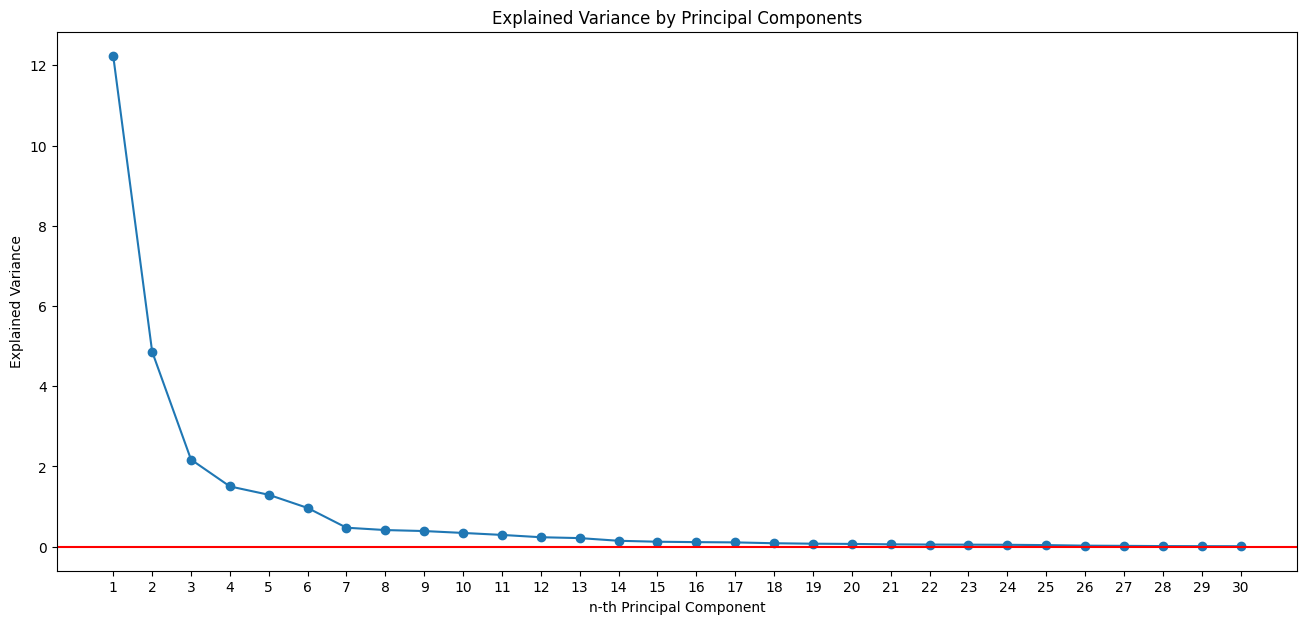

In [14]:
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(imputed_df)

# Plot explained variance of each principal component
plt.figure(figsize=(16,7))
explained_variance_ = pca.explained_variance_
plt.plot(explained_variance_, marker='o')
plt.xticks(np.arange(len(explained_variance_)), np.arange(1, len(explained_variance_)+1)) # index shift by 1
plt.xlabel('n-th Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Wee see that the first couple principal components make up the majority of the explained variance in our data. After about 3 components, each principal component starts to "level off" in terms of the level of variance they explain. After 7 components, the effect of each principal component is minor. We can also observe the total percentage of explained ratio kept by keeping the first $n$ principal components:

In [15]:
for i in range(7):
  pca = PCA(n_components=i+1)
  X_pca = pca.fit_transform(imputed_df)
  print(f'The percentage of explained variance when n={i+1} is: {sum(pca.explained_variance_ratio_)*100:.2f} %')

The percentage of explained variance when n=1 is: 46.24 %
The percentage of explained variance when n=2 is: 64.63 %
The percentage of explained variance when n=3 is: 72.84 %
The percentage of explained variance when n=4 is: 78.52 %
The percentage of explained variance when n=5 is: 83.42 %
The percentage of explained variance when n=6 is: 87.07 %
The percentage of explained variance when n=7 is: 88.86 %


There is no strict guideline on exactly how much explained variance we should strive to capture but [some sources](https://stats.oarc.ucla.edu/spss/seminars/efa-spss/) say we should strive for ~70-80% (choice may be context dependant). We do not want to overencumber our model by adding too many features just for the sake of trying to minimally improve our explained variance ratio. Choosing $n=4$ seems like a reasonable choice based on the above, but we will later us k-fold cross validation across several values of $n$ to find the optimal value for modelling.

Now let's build our decision tree model with our original data (with KNN values assigned to randomly missing values). We will create other models with PCA afterwards so we can first find a proper value for $n$.

We have to revert our scaling for the original data, since we want the scaling on our data to be segregated into training data and test dat. Otherwise, the data from the test data would potentially be impacting the calculation of mean and standard deviation of our training data during the standardization process, and the test data should have no impact on our model during training. This cannot be done for our PCA data, since the PCA coefficients were calculated after scaling and inverse scaling would not make sense on the new principal components which are linear combinations of various old features. We do not need to rescale the data after the train-test split, since decision tree models are essentially indifferent to scaling due to how data is split at certain threshold levels in features which would also simply be scaled if the data was transformed.

Additionally, we will convert our $y$ back into categorical classes so that we can use a decision tree classifier rather than a regressor.

Then we will split our data into training data and test data, then perform the proper scaling:

In [16]:
from sklearn.model_selection import train_test_split

# Return original data into non-standardized variant.
X = pd.DataFrame(scaler.inverse_transform(imputed_df), columns=imputed_df.columns)

# Return y back into categorical data
y=y.replace(1, "Malignant")
y=y.replace(0, "Benign")

# Perform train-test split on non-standardized original data, then standardize based only on the training data
# so that the test data does not manipulate the standardization of the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3141592, stratify=y)

We will now create our decision tree and include our metrics for measuring its efficiency. Since we are using a decision tree classifier, we do not measure by $R^2$ or MSE, but we can measure efficiency via accuracy, precision, recall, and F1-score.

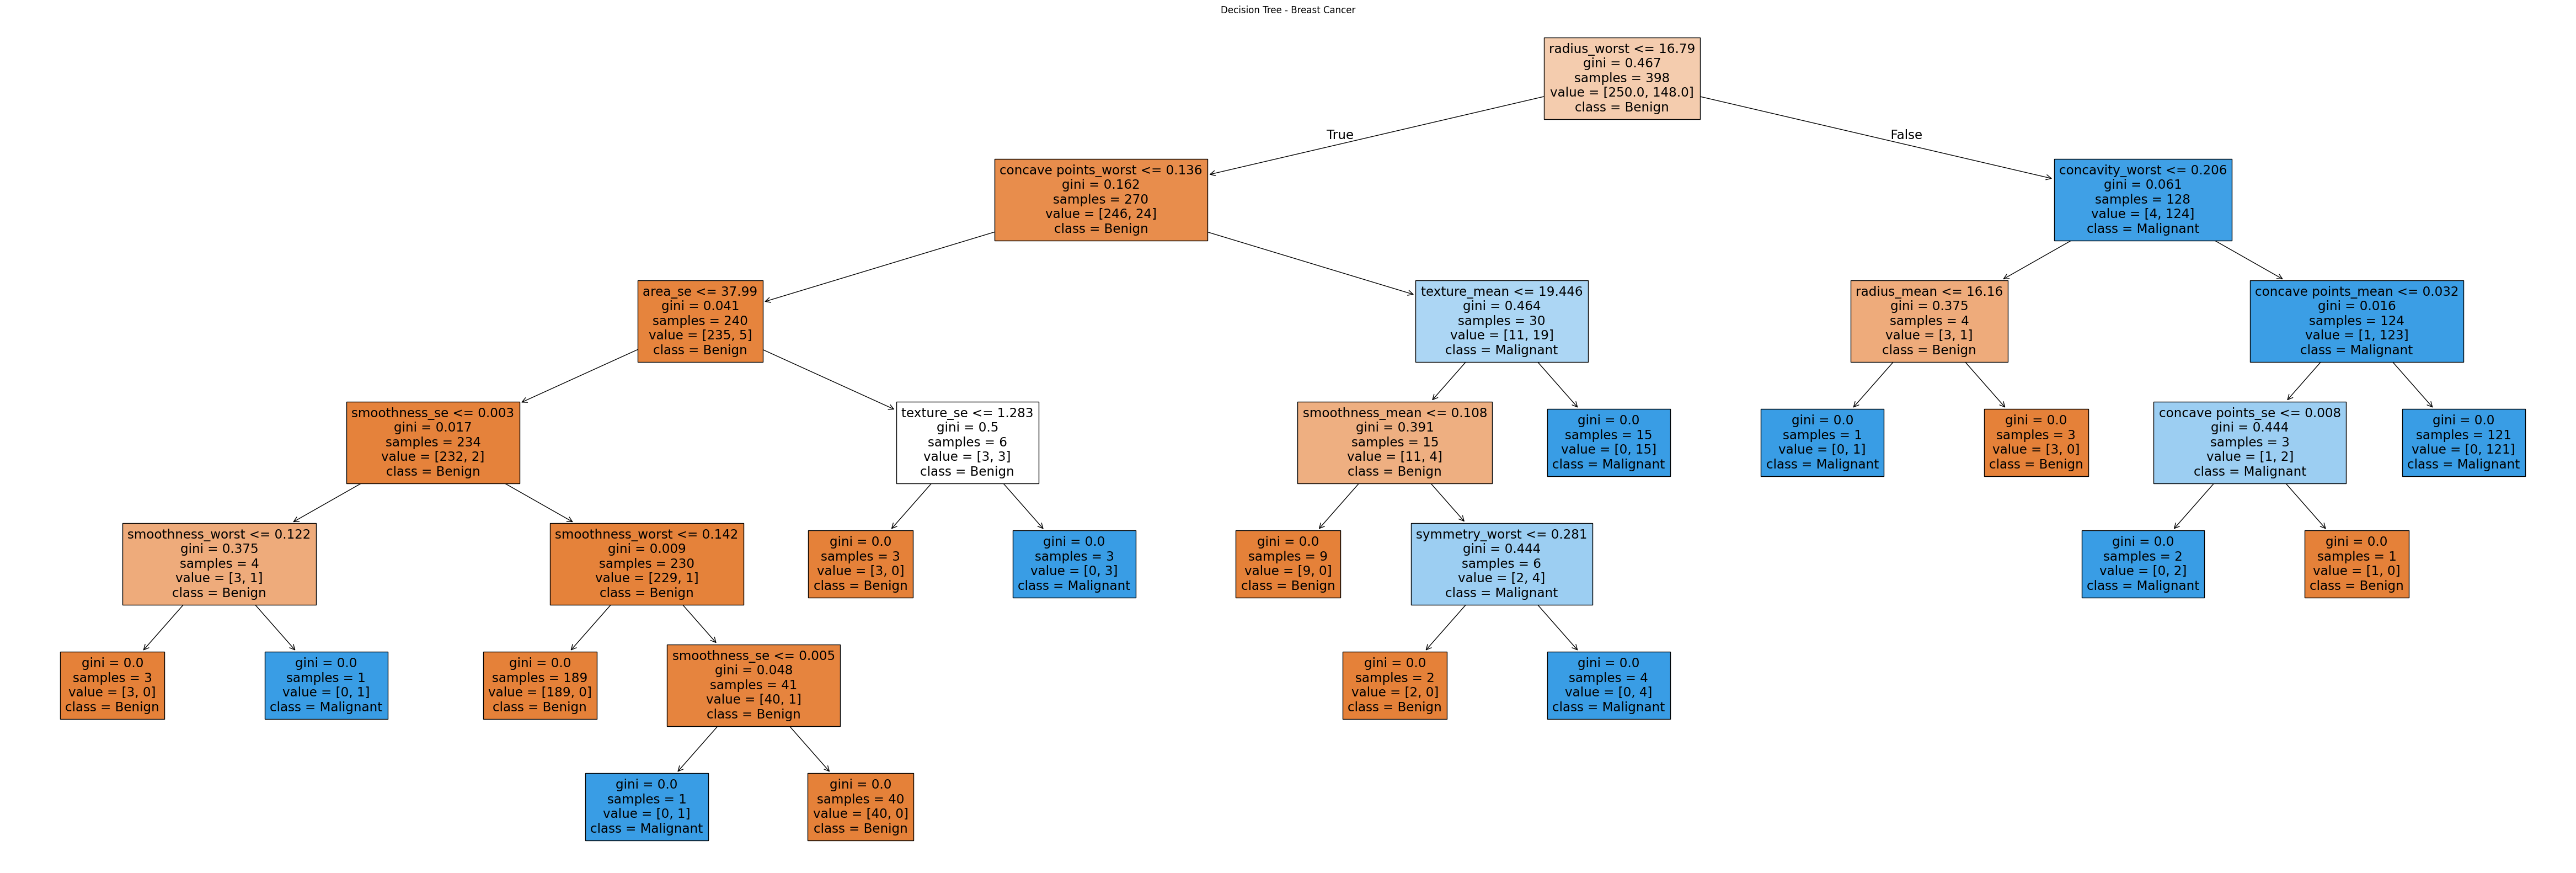

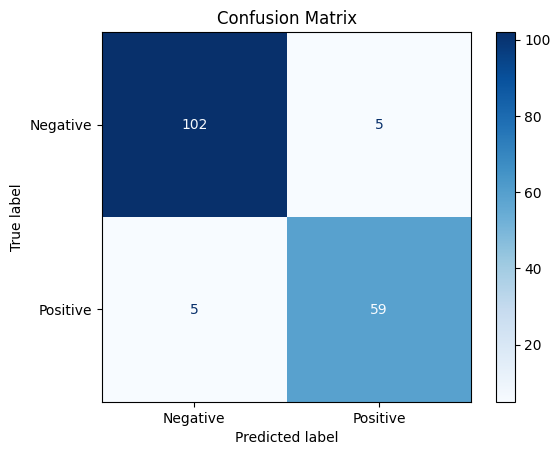

Accuracy of Decision Tree classifier on test set: 0.9415204678362573
Recall of Decision Tree classifier on test set: 0.921875
Precision of Decision Tree classifier on test set: 0.921875
F1-score of Decision Tree classifier on test set: 0.921875


In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

BCTree = DecisionTreeClassifier(random_state=3141592)
BCTree.fit(X_train, y_train)

plt.figure(figsize=(60, 20))
plot_tree(BCTree, filled=True, feature_names=X.columns, class_names=["Benign", "Malignant"])
plt.title('Decision Tree - Breast Cancer')
plt.show()

y_pred = BCTree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
precision = cm[1,1]/(cm[1,1]+cm[0,1]) # Precision = TP/(TP+FP)
recall = cm[1,1]/(cm[1,1]+cm[1,0]) # Recall = TP/(TP+FN)
f1score = 2/(1/precision+1/recall)
print("Accuracy of Decision Tree classifier on test set:", accuracy)
print("Recall of Decision Tree classifier on test set:", recall)
print("Precision of Decision Tree classifier on test set:", precision)
print("F1-score of Decision Tree classifier on test set:", f1score)

Our model performs fairly well on the data. However, recall is an important metric in the context of our data, and we may be disappointed in the value of it not being extremely close to 1. We do not want our model to fail to recognize a patient with a malignant mass as having a malignant mass. A false positive can be dealt with by further experimentation, but a false negative may cause a patient to not receive the proper level of attention they deserve.

Now let's train our model using the PCA data rather than the original data. Before we can choose an optimal number of PCA components, we will perform stratified K-folds cross validation to review the accuracy of certain values of $n$. Whichever $n$ value gives the best average accuracy will be our choice of $n$ for our primary model.

In [18]:
from sklearn.model_selection import StratifiedKFold
import random

for i in range(30):
  ncomp=i+1
  pca = PCA(n_components=ncomp)
  X_pca = pca.fit_transform(imputed_df)
  XPCA_train, XPCA_test, yPCA_train, yPCA_test = train_test_split(X_pca, y, test_size=0.3, random_state=3141592)

  decision_tree_model = DecisionTreeClassifier()

  # Prepare StratifiedKFold cross-validation
  random_state = random.randint(0, 99999)
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

  # Initialize list to collect fold results
  accuracies = []

  # Perform StratifiedKFold cross-validation using the PCA-reduced dataset
  for i, (train_index, test_index) in enumerate(skf.split(X_pca, y)):
      XPCA_train, XPCA_test = X_pca[train_index], X_pca[test_index]
      yPCA_train, yPCA_test = y[train_index], y[test_index]

      # Train the model
      decision_tree_model.fit(XPCA_train, yPCA_train)

      # Predict on the test set
      yPCA_pred = decision_tree_model.predict(XPCA_test)

      # Calculate accuracy
      accuracy = accuracy_score(yPCA_test, yPCA_pred)
      accuracies.append(accuracy)

  # Print accuracies
  print(f'Average accuracy for n={ncomp}, {np.mean(accuracies)}')

Average accuracy for n=1, 0.875281954887218
Average accuracy for n=2, 0.9296679197994988
Average accuracy for n=3, 0.9244047619047618
Average accuracy for n=4, 0.9278822055137844
Average accuracy for n=5, 0.9296052631578947
Average accuracy for n=6, 0.9332393483709274
Average accuracy for n=7, 0.924436090225564
Average accuracy for n=8, 0.9367481203007518
Average accuracy for n=9, 0.92453007518797
Average accuracy for n=10, 0.9227443609022556
Average accuracy for n=11, 0.9172932330827068
Average accuracy for n=12, 0.9173872180451129
Average accuracy for n=13, 0.9279135338345865
Average accuracy for n=14, 0.9139097744360903
Average accuracy for n=15, 0.9261591478696742
Average accuracy for n=16, 0.9138157894736842
Average accuracy for n=17, 0.924436090225564
Average accuracy for n=18, 0.9262844611528822
Average accuracy for n=19, 0.9156641604010025
Average accuracy for n=20, 0.9049812030075186
Average accuracy for n=21, 0.9208959899749374
Average accuracy for n=22, 0.9157268170426065
Av

As we can see, most choices of $n$ still leave our model with reasonably good accuracy. Repeating this code several times, it was observed that:
* $n=1$ tended to always provide an accuracy of around $88\%$,
* $n=2$ tended to always provide an accuracy of around $90\%$,
* $n=3,4,\dots,10$ provided a typical accuracy of around $90$ to $94\%$
* $n=11,12,\dots,30$ provided a typical accuracy of around  $90$ to $92\%$

It is difficult to declare what the optimal number of principal components is based on the k-folds validation, as the simulations appear to vary near similar values. We can see that $n=1$ and $n=2$ do provide a consistently lower accuracy than larger $n$ values, but we have to remember that the point of PCA is to reduce dimensions, so we should try to choose a value of $n$ such that we maintain minimal principal components without sacrificing accuracy. For this reason, we should choose $n=3$ as an optimal number of principal components. This also coinsides with our scree point in the previous plot of explained variances amongst principal components, so we have two experiments to justify our choice. Now lets repeat the decision tree model fully but with the PCA data such that $n=3$.

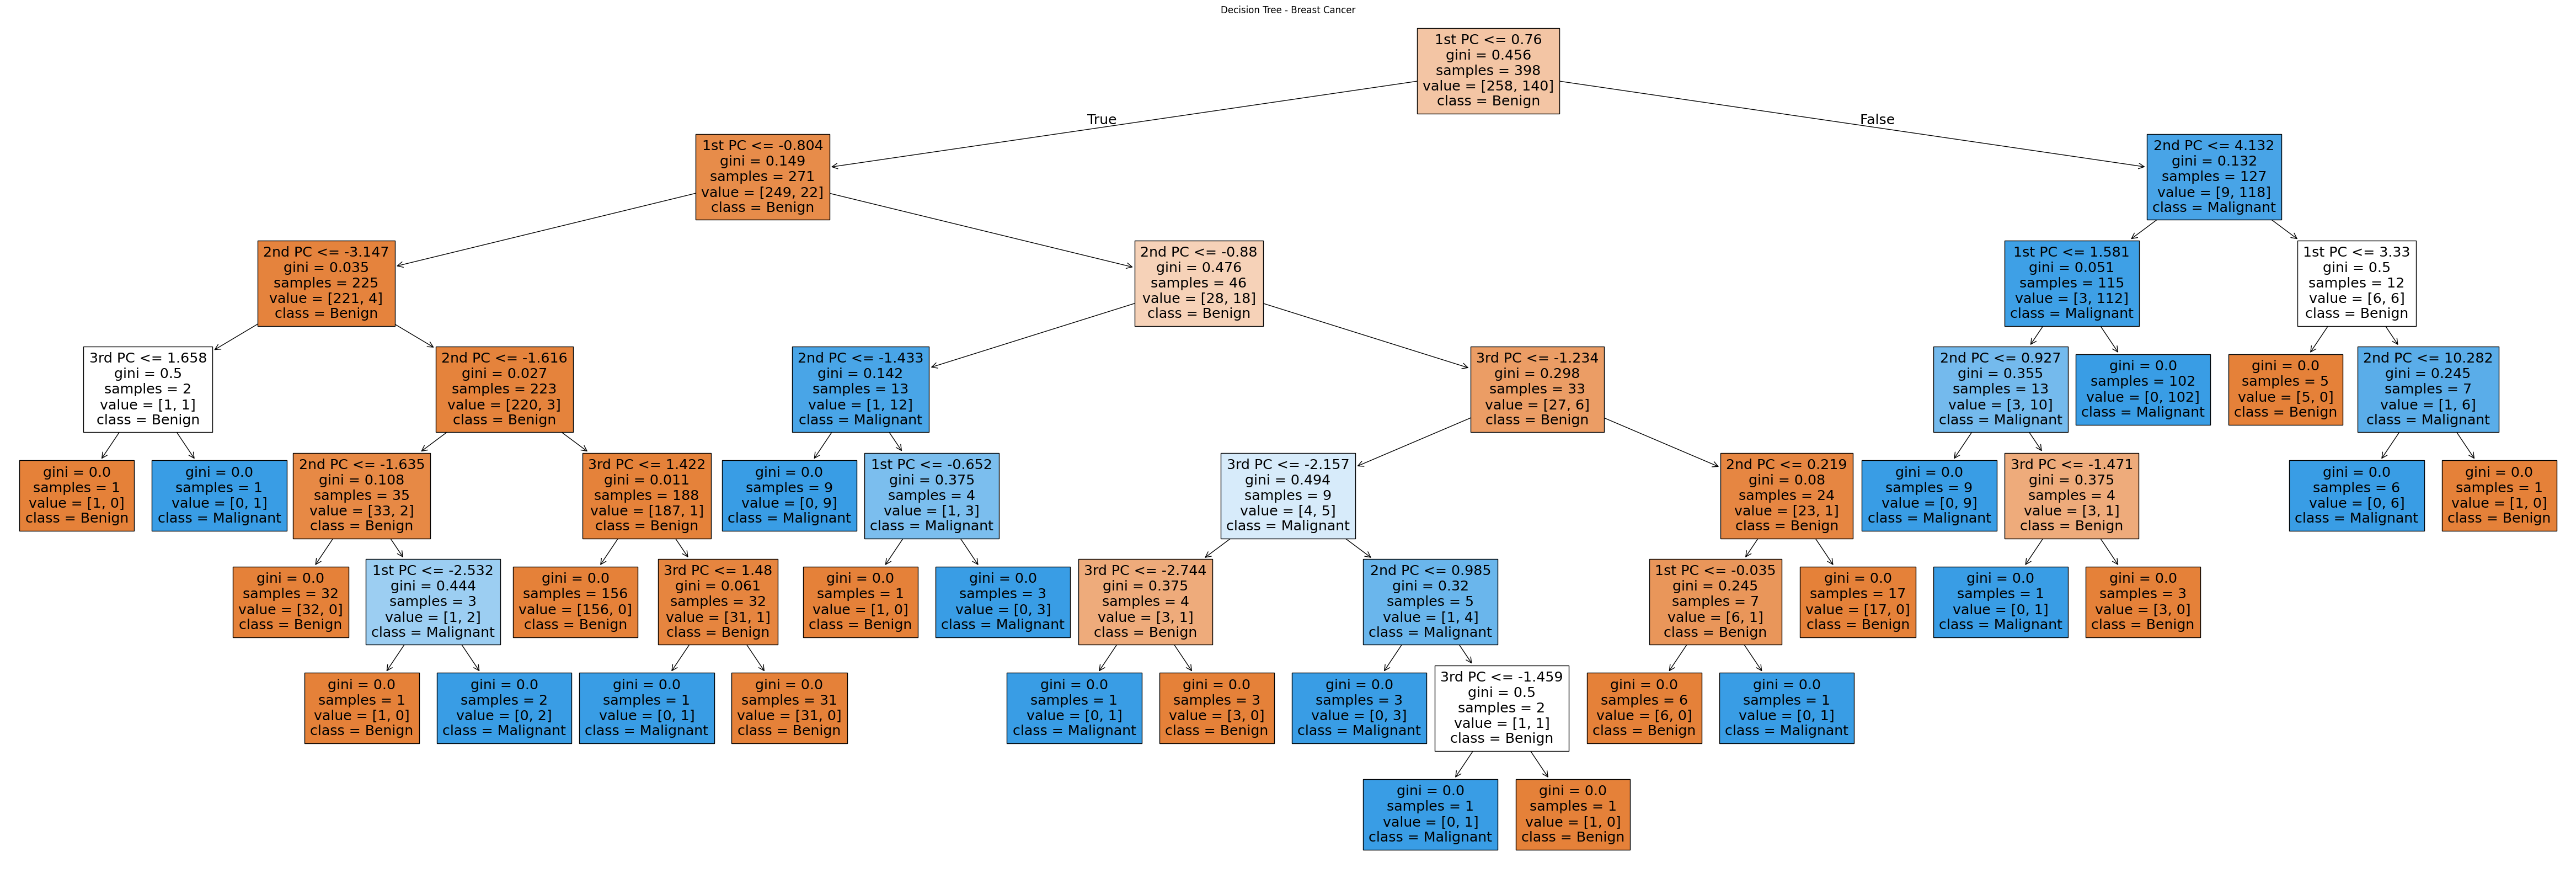

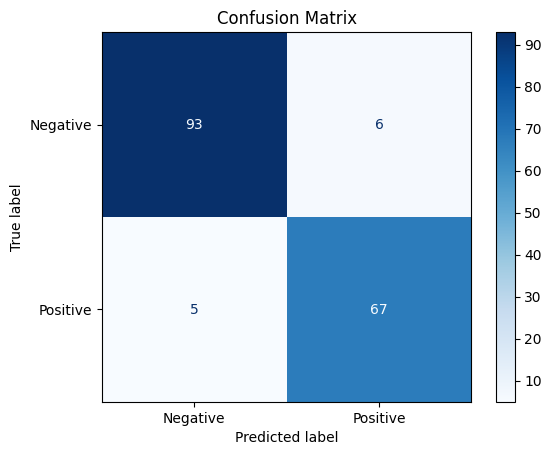

Accuracy of Decision Tree classifier on test set: 0.935672514619883
Recall of Decision Tree classifier on test set: 0.9305555555555556
Precision of Decision Tree classifier on test set: 0.9178082191780822
F1-score of Decision Tree classifier on test set: 0.9241379310344826


In [19]:
# Another train-test split for our PCA data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(imputed_df)
XPCA_train, XPCA_test, yPCA_train, yPCA_test = train_test_split(X_pca, y, test_size=0.3, random_state=31415)

BCTree2 = DecisionTreeClassifier(random_state=31415)
BCTree2.fit(XPCA_train, yPCA_train)

plt.figure(figsize=(60, 20))
plot_tree(BCTree2, filled=True, feature_names=["1st PC", "2nd PC", "3rd PC"], class_names=["Benign", "Malignant"])
plt.title('Decision Tree - Breast Cancer')
plt.show()

yPCA_pred = BCTree2.predict(XPCA_test)

cm = confusion_matrix(yPCA_test, yPCA_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(yPCA_test, yPCA_pred)
precision = cm[1,1]/(cm[1,1]+cm[0,1]) # Precision = TP/(TP+FP)
recall = cm[1,1]/(cm[1,1]+cm[1,0]) # Recall = TP/(TP+FN)
f1score = 2/(1/precision+1/recall)
print("Accuracy of Decision Tree classifier on test set:", accuracy)
print("Recall of Decision Tree classifier on test set:", recall)
print("Precision of Decision Tree classifier on test set:", precision)
print("F1-score of Decision Tree classifier on test set:", f1score)

We see that each of our final metrics are greater than our metrics from our model generated from the original data (though not greatly so). The computation of our model was also executed faster, as the model only relied on 3 features and less calculations were required. The readability of the model was damaged, since it may be hard to explain what one of the principal component is representing to a non-technical audience, but the overall performance was slightly improved. Repeated simulations across various random seeds still typically provided accuracy increases over our old model, typically around $0.91$.

# Feature Importance


As we have done before in our previous assignment, we can extract the feature importance from both of our decision tree models to visualize which features contribute the most to our predictions.

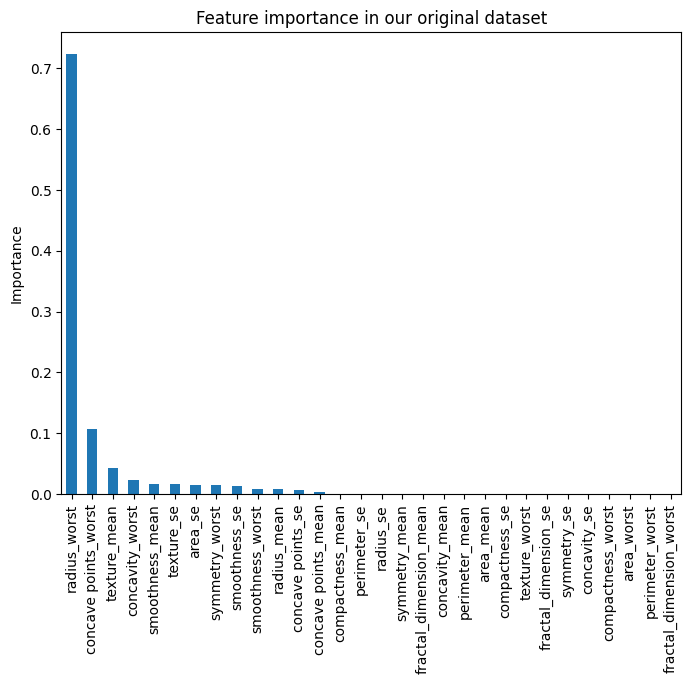

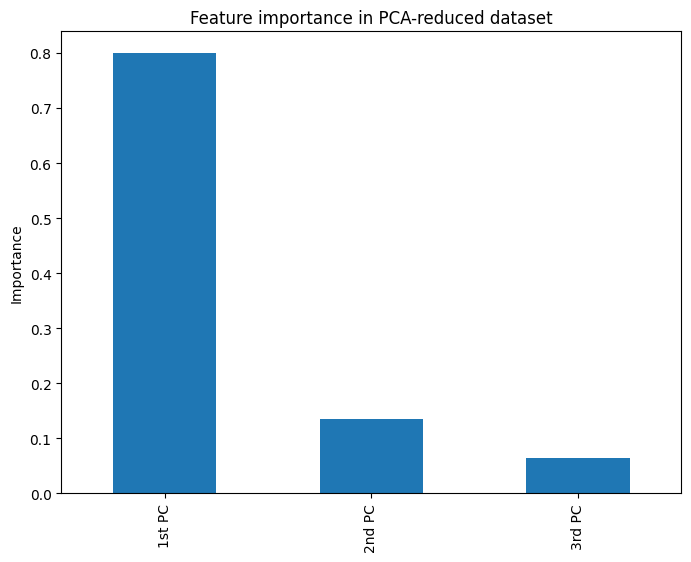

In [20]:
feat_importances = pd.DataFrame(BCTree.feature_importances_, index=X_train.columns, columns=["Importance"]) # We write a dataframe that contains the feature importances of our data from our model.
feat_importances.sort_values(by='Importance', ascending=False, inplace=True) # Arranging the data from greatest to least
feat_importances.plot(kind='bar', figsize=(8,6), ylabel="Importance", legend=False)
plt.title("Feature importance in our original dataset")
plt.show()
print("\n")
feat_importances = pd.DataFrame(BCTree2.feature_importances_, index=["1st PC", "2nd PC", "3rd PC"], columns=["Importance"]) # We write a dataframe that contains the feature importances of our data from our model.
feat_importances.sort_values(by='Importance', ascending=False, inplace=True) # Arranging the data from greatest to least
feat_importances.plot(kind='bar', figsize=(8,6), ylabel="Importance", legend=False)
plt.title("Feature importance in PCA-reduced dataset")
plt.show()

We can observe our first plot to see that, by far, the most important feature to detect malignant breast cancer tumors is if there is a large number of concave points in the masses on average. Concave points amongst masses may indicated unfettered and erratic growth in tumors, which would be a stronger indicator of malignancy than other factors. We could explain this result to the public by using this result to stress that chaotic growth is a stronger indicator of breast cancer than larger lumps. We also see that most of the other relevant features, aside from worst symmetry, are metrics of size (perimeter, area, radius), so we can still say that those are relevant factors for classifying masses as malignant or benign. Beyond "radius_mean", no other factors appear in our decision tree model. We could safely remove those features from our model and improve its performance without damaging the model integrity, since those features did not have any relevance. We may even also remove some of the lower end feataures and inspect our model's preformance, though those features still have at least some relevance (but their contribution to overfitting may not justify their existnace).

In our second plot, we only have our 3 principal components, and our results were predictable. We knew from the explained variance graph that our principal components' importance was descending, and that the first principal component greatly overshadowed the amount of variance it explained over other principal components. It would be difficult to explain these components to the public, but we can use results from the first plot and our covariance matrix to make reasonable assumptions. For example, mean concave points is the most important feature, and it is also strongly correlated to mean compactness and mean concavity, which are all metrics revolving around the masses' shapes. We could arguably claim that the first principal component is a linear combination of features primarily weighted towards these shape parameters, so its possible that the first component is indicative of a broad "shape" feature describing the masses, for example. We would not need to reduce the number of features in this model, since that was already done during the PCA and k-folds decision process.

---

Dataset source:

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

---

Coding assistance sources:

6601 Regression notebook

https://saturncloud.io/blog/what-is-sklearn-pca-explained-variance-and-explained-variance-ratio-difference/

---

Theory assistance sources:

6601 Decision Tree notebook

6601 Decision Tree lecture slides

https://en.wikipedia.org/wiki/Compactness_measure

https://en.wikipedia.org/wiki/Fractal_dimension

https://medium.com/analytics-vidhya/effectiveness-of-knn-imputation-part-i-the-iris-dataset-e784f157275a

https://saturncloud.io/blog/what-is-sklearn-pca-explained-variance-and-explained-variance-ratio-difference/

https://stats.oarc.ucla.edu/spss/seminars/efa-spss/

